<a href="https://colab.research.google.com/github/Wanita-8943/efficientnet_keras_transfer_learning/blob/master/Train_Male_200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [1]:
import pandas as pd
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv (r'/content/drive/MyDrive/cut_panoramic/Flim_pano_Male.csv')
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Filename,Path_filename,Sex,Floder
0,1,1,7,Y7M,VV03.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
1,2,1,7,Y7M,Flip_VV03.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
2,3,2,7,Y7M,VV04.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
3,4,2,7,Y7M,Flip_VV04.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
4,5,3,7,Y7M,VV05.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
...,...,...,...,...,...,...,...,...
2339,71,50,25,Y25M,J146.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt
2340,72,51,25,Y25M,J166.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt
2341,73,52,25,Y25M,J169.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt
2342,74,53,25,Y25M,J183.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt


##ขาดอายุ 14

In [4]:
classes = ['Y7M','Y8M','Y9M','Y10M','Y11M','Y12M','Y13M','15M','Y16M','Y17M','Y18M','Y19M','Y20M','Y21M','Y22M','Y23M','Y24M','Y25M']
len(classes)

18

In [5]:
df.shape

(2344, 8)

In [6]:
print(set(df['Class']))
print(set(df['Sex']))
print(set(df['Floder']))

{'Y11M', 'Y7M', 'Y8M', 'Y15M', 'Y12M', 'Y16M', 'Y17M', 'Y19M', 'Y23M', 'Y24M', 'Y20M', 'Y13M', 'Y22M', 'Y10M', 'Y9M', 'Y21M', 'Y25M', 'Y18M'}
{'เพศชาย'}
{'Lt', 'Both', 'Rt'}


#Imports

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

#กำหนดค่าพารามิเตอร์


In [33]:
batch_size = 16
width = 150
height = 150
epochs = 200
NUM_TRAIN = 1084
NUM_TEST = 134
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [9]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 374, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 374 (delta 149), reused 157 (delta 130), pack-reused 184
Receiving objects: 100% (374/374), 7.77 MiB | 7.44 MiB/s, done.
Resolving deltas: 100% (222/222), done.
/content/efficientnet_keras_transfer_learning


In [10]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [11]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

16717576/16717576 [==============================] - 2s 0us/step


In [12]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                    

#สร้างโฟลเดอร์ Train Valodation และ Test

In [18]:
base_dir = '/content/drive/My Drive/TVT_Male'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

##สร้างโฟลเดอร์ Train ของแต่ละอายุและแบ่งเป็นเพศหญิงและเพศชาย

In [19]:
train_Y7M_dir = os.path.join(train_dir, 'Y7M')
os.makedirs(train_Y7M_dir, exist_ok=True)

train_Y8M_dir = os.path.join(train_dir, 'Y8M')
os.makedirs(train_Y8M_dir, exist_ok=True)

train_Y9M_dir = os.path.join(train_dir, 'Y9M')
os.makedirs(train_Y9M_dir, exist_ok=True)

train_Y10M_dir = os.path.join(train_dir, 'Y10M')
os.makedirs(train_Y10M_dir, exist_ok=True)

train_Y11M_dir = os.path.join(train_dir, 'Y11M')
os.makedirs(train_Y11M_dir, exist_ok=True)

train_Y12M_dir = os.path.join(train_dir, 'Y12M')
os.makedirs(train_Y12M_dir, exist_ok=True)

train_Y13M_dir = os.path.join(train_dir, 'Y13M')
os.makedirs(train_Y13M_dir, exist_ok=True)

# train_Y13_dir = os.path.join(train_dir, 'Y14M')
# os.makedirs(train_Y13_dir, exist_ok=True)

train_Y15M_dir = os.path.join(train_dir, 'Y15M')
os.makedirs(train_Y15M_dir, exist_ok=True)

train_Y16M_dir = os.path.join(train_dir, 'Y16M')
os.makedirs(train_Y16M_dir, exist_ok=True)

train_Y17M_dir = os.path.join(train_dir, 'Y17M')
os.makedirs(train_Y17M_dir, exist_ok=True)

train_Y18M_dir = os.path.join(train_dir, 'Y18M')
os.makedirs(train_Y18M_dir, exist_ok=True)

train_Y19M_dir = os.path.join(train_dir, 'Y19M')
os.makedirs(train_Y19M_dir, exist_ok=True)

train_Y20M_dir = os.path.join(train_dir, 'Y20M')
os.makedirs(train_Y20M_dir, exist_ok=True)

train_Y21M_dir = os.path.join(train_dir, 'Y21M')
os.makedirs(train_Y21M_dir, exist_ok=True)

train_Y22M_dir = os.path.join(train_dir, 'Y22M')
os.makedirs(train_Y22M_dir, exist_ok=True)

train_Y23M_dir = os.path.join(train_dir, 'Y23M')
os.makedirs(train_Y23M_dir, exist_ok=True)

train_Y24M_dir = os.path.join(train_dir, 'Y24M')
os.makedirs(train_Y24M_dir, exist_ok=True)

train_Y25M_dir = os.path.join(train_dir, 'Y25M')
os.makedirs(train_Y25M_dir, exist_ok=True)

##สร้างโฟลเดอร์ Validation ของแต่ละอายุและแบ่งเป็นเพศหญิงและเพศชาย

In [20]:
validation_Y7M_dir = os.path.join(validation_dir, 'Y7M')
os.makedirs(validation_Y7M_dir, exist_ok=True)


validation_Y8M_dir = os.path.join(validation_dir, 'Y8M')
os.makedirs(validation_Y8M_dir, exist_ok=True)


validation_Y9M_dir = os.path.join(validation_dir, 'Y9M')
os.makedirs(validation_Y9M_dir, exist_ok=True)


validation_Y10M_dir = os.path.join(validation_dir, 'Y10M')
os.makedirs(validation_Y10M_dir, exist_ok=True)

validation_Y11M_dir = os.path.join(validation_dir, 'Y11M')
os.makedirs(validation_Y11M_dir, exist_ok=True)

validation_Y12M_dir = os.path.join(validation_dir, 'Y12M')
os.makedirs(validation_Y12M_dir, exist_ok=True)

validation_Y13M_dir = os.path.join(validation_dir, 'Y13M')
os.makedirs(validation_Y13M_dir, exist_ok=True)

# validation_Y14M_dir = os.path.join(validation_dir, 'Y14M')
# os.makedirs(validation_Y14M_dir, exist_ok=True)

validation_Y15M_dir = os.path.join(validation_dir, 'Y15M')
os.makedirs(validation_Y15M_dir, exist_ok=True)

validation_Y16M_dir = os.path.join(validation_dir, 'Y16M')
os.makedirs(validation_Y16M_dir, exist_ok=True)

validation_Y17M_dir = os.path.join(validation_dir, 'Y17M')
os.makedirs(validation_Y17M_dir, exist_ok=True)

validation_Y18M_dir = os.path.join(validation_dir, 'Y18M')
os.makedirs(validation_Y18M_dir, exist_ok=True)

validation_Y19M_dir = os.path.join(validation_dir, 'Y19M')
os.makedirs(validation_Y19M_dir, exist_ok=True)

validation_Y20M_dir = os.path.join(validation_dir, 'Y20M')
os.makedirs(validation_Y20M_dir, exist_ok=True)

validation_Y21M_dir = os.path.join(validation_dir, 'Y21M')
os.makedirs(validation_Y21M_dir, exist_ok=True)

validation_Y22M_dir = os.path.join(validation_dir, 'Y22M')
os.makedirs(validation_Y22M_dir, exist_ok=True)

validation_Y23M_dir = os.path.join(validation_dir, 'Y23M')
os.makedirs(validation_Y23M_dir, exist_ok=True)

validation_Y24M_dir = os.path.join(validation_dir, 'Y24M')
os.makedirs(validation_Y24M_dir, exist_ok=True)

validation_Y25M_dir = os.path.join(validation_dir, 'Y25M')
os.makedirs(validation_Y25M_dir, exist_ok=True)

##สร้างโฟลเดอร์ Test ของแต่ละอายุและแบ่งเป็นเพศหญิงและเพศชาย

In [21]:
test_Y7M_dir = os.path.join(test_dir, 'Y7M')
os.makedirs(test_Y7M_dir, exist_ok=True)

test_Y8M_dir = os.path.join(test_dir, 'Y8M')
os.makedirs(test_Y8M_dir, exist_ok=True)


test_Y9M_dir = os.path.join(test_dir, 'Y9M')
os.makedirs(test_Y9M_dir, exist_ok=True)

test_Y10M_dir = os.path.join(test_dir, 'Y10M')
os.makedirs(test_Y10M_dir, exist_ok=True)

test_Y11M_dir = os.path.join(test_dir, 'Y11M')
os.makedirs(test_Y11M_dir, exist_ok=True)


test_Y12M_dir = os.path.join(test_dir, 'Y12M')
os.makedirs(test_Y12M_dir, exist_ok=True)


test_Y13M_dir = os.path.join(test_dir, 'Y13M')
os.makedirs(test_Y13M_dir, exist_ok=True)


# test_Y14M_dir = os.path.join(test_dir, 'Y14M')
# os.makedirs(test_Y14M_dir, exist_ok=True)


test_Y15M_dir = os.path.join(test_dir, 'Y15M')
os.makedirs(test_Y15M_dir, exist_ok=True)


test_Y16M_dir = os.path.join(test_dir, 'Y16M')
os.makedirs(test_Y16M_dir, exist_ok=True)


test_Y17M_dir = os.path.join(test_dir, 'Y17M')
os.makedirs(test_Y17M_dir, exist_ok=True)


test_Y18M_dir = os.path.join(test_dir, 'Y18M')
os.makedirs(test_Y18M_dir, exist_ok=True)


test_Y19M_dir = os.path.join(test_dir, 'Y19M')
os.makedirs(test_Y19M_dir, exist_ok=True)


test_Y20M_dir = os.path.join(test_dir, 'Y20M')
os.makedirs(test_Y20M_dir, exist_ok=True)


test_Y21M_dir = os.path.join(test_dir, 'Y21M')
os.makedirs(test_Y21M_dir, exist_ok=True)


test_Y22M_dir = os.path.join(test_dir, 'Y22M')
os.makedirs(test_Y22M_dir, exist_ok=True)


test_Y23M_dir = os.path.join(test_dir, 'Y23M')
os.makedirs(test_Y23M_dir, exist_ok=True)


test_Y24M_dir = os.path.join(test_dir, 'Y24M')
os.makedirs(test_Y24M_dir, exist_ok=True)


test_Y25M_dir = os.path.join(test_dir, 'Y25M')
os.makedirs(test_Y25M_dir, exist_ok=True)

In [22]:
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Filename,Path_filename,Sex,Floder
0,1,1,7,Y7M,VV03.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
1,2,1,7,Y7M,Flip_VV03.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
2,3,2,7,Y7M,VV04.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
3,4,2,7,Y7M,Flip_VV04.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
4,5,3,7,Y7M,VV05.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
...,...,...,...,...,...,...,...,...
2339,71,50,25,Y25M,J146.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt
2340,72,51,25,Y25M,J166.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt
2341,73,52,25,Y25M,J169.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt
2342,74,53,25,Y25M,J183.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt


In [23]:
val = df[df['Fig_Person_Sex'].between(33,36)]
train = df[df['Fig_Person_Sex'].between(1,32)]
test = df[df['Fig_Person_Sex'].between(37,40)]

#Path Train
Y7M_train = train[train['Class']=='Y7M' ]
Y7M_path_train = Y7M_train['Path_filename'].tolist() 

Y8M_train = train[train['Class']=='Y8M' ]
Y8M_path_train = Y8M_train['Path_filename'].tolist() 

Y9M_train = train[train['Class']=='Y9M' ]
Y9M_path_train = Y9M_train['Path_filename'].tolist()

Y10M_train = train[train['Class']=='Y10M' ]
Y10M_path_train = Y10M_train['Path_filename'].tolist()

Y11M_train = train[train['Class']=='Y11M' ]
Y11M_path_train = Y11M_train['Path_filename'].tolist()

Y12M_train = train[train['Class']=='Y12M' ]
Y12M_path_train = Y12M_train['Path_filename'].tolist()

Y13M_train = train[train['Class']=='Y13M' ]
Y13M_path_train = Y13M_train['Path_filename'].tolist()

# Y14M_train = train[train['Class']=='Y14M' ]
# Y14M_path_train = Y14M_train['Path_filename'].tolist()

Y15M_train = train[train['Class']=='Y15M' ]
Y15M_path_train = Y15M_train['Path_filename'].tolist()

Y16M_train = train[train['Class']=='Y16M' ]
Y16M_path_train = Y16M_train['Path_filename'].tolist() 

Y17M_train = train[train['Class']=='Y17M' ]
Y17M_path_train = Y17M_train['Path_filename'].tolist()

Y18M_train = train[train['Class']=='Y18M' ]
Y18M_path_train = Y18M_train['Path_filename'].tolist()

Y19M_train = train[train['Class']=='Y19M' ]
Y19M_path_train = Y19M_train['Path_filename'].tolist()

Y20M_train = train[train['Class']=='Y20M' ]
Y20M_path_train = Y20M_train['Path_filename'].tolist()

Y21M_train = train[train['Class']=='Y21M' ]
Y21M_path_train = Y21M_train['Path_filename'].tolist()

Y22M_train = train[train['Class']=='Y22M' ]
Y22M_path_train = Y22M_train['Path_filename'].tolist()

Y23M_train = train[train['Class']=='Y23M' ]
Y23M_path_train = Y23M_train['Path_filename'].tolist()

Y24M_train = train[train['Class']=='Y24M' ]
Y24M_path_train = Y24M_train['Path_filename'].tolist()

Y25M_train = train[train['Class']=='Y25M' ]
Y25M_path_train = Y25M_train['Path_filename'].tolist()

#Path Validation
Y7M_val = val[val['Class']=='Y7M' ]
Y7M_path_val = Y7M_val['Path_filename'].tolist() 

Y8M_val = val[val['Class']=='Y8M' ]
Y8M_path_val = Y8M_val['Path_filename'].tolist() 

Y9M_val = val[val['Class']=='Y9M' ]
Y9M_path_val = Y9M_val['Path_filename'].tolist()

Y10M_val = val[val['Class']=='Y10M' ]
Y10M_path_val = Y10M_val['Path_filename'].tolist()

Y11M_val = val[val['Class']=='Y11M' ]
Y11M_path_val = Y11M_val['Path_filename'].tolist()

Y12M_val = val[val['Class']=='Y12M' ]
Y12M_path_val = Y12M_val['Path_filename'].tolist()

Y13M_val = val[val['Class']=='Y13M' ]
Y13M_path_val = Y13M_val['Path_filename'].tolist()

# Y14M_val = val[val['Class']=='Y14M' ]
# Y14M_path_val = Y14M_val['Path_filename'].tolist()

Y15M_val = val[val['Class']=='Y15M' ]
Y15M_path_val = Y15M_val['Path_filename'].tolist()

Y16M_val = val[val['Class']=='Y16M' ]
Y16M_path_val = Y16M_val['Path_filename'].tolist() 

Y17M_val = val[val['Class']=='Y17M' ]
Y17M_path_val = Y17M_val['Path_filename'].tolist()

Y18M_val  = val[val ['Class']=='Y18M' ]
Y18M_path_val = Y18M_val['Path_filename'].tolist()

Y19M_val = val[val['Class']=='Y19M' ]
Y19M_path_val = Y19M_val['Path_filename'].tolist()

Y20M_val = val[val['Class']=='Y20M' ]
Y20M_path_val = Y20M_val['Path_filename'].tolist()

Y21M_val = val[val['Class']=='Y21M' ]
Y21M_path_val = Y21M_val['Path_filename'].tolist()

Y22M_val = val[val['Class']=='Y22M' ]
Y22M_path_val = Y22M_val['Path_filename'].tolist()

Y23M_val = val[val['Class']=='Y23M' ]
Y23M_path_val = Y23M_val['Path_filename'].tolist()

Y24M_val = val[val['Class']=='Y24M' ]
Y24M_path_val = Y24M_val['Path_filename'].tolist()

Y25M_val = val[val['Class']=='Y25M' ]
Y25M_path_val = Y25M_val['Path_filename'].tolist()


#Path Test
Y7M_test = test[test['Class']=='Y7M' ]
Y7M_path_test = Y7M_test['Path_filename'].tolist() 

Y8M_test = test[test['Class']=='Y8M' ]
Y8M_path_test = Y8M_test['Path_filename'].tolist() 

Y9M_test = test[test['Class']=='Y9M' ]
Y9M_path_test = Y9M_test['Path_filename'].tolist()

Y10M_test = test[test['Class']=='Y10M' ]
Y10M_path_test = Y10M_test['Path_filename'].tolist()

Y11M_test = test[test['Class']=='Y11M' ]
Y11M_path_test = Y11M_test['Path_filename'].tolist()

Y12M_test = test[test['Class']=='Y12M' ]
Y12M_path_test = Y12M_test['Path_filename'].tolist()

Y13M_test = test[test['Class']=='Y13M' ]
Y13M_path_test = Y13M_test['Path_filename'].tolist()

# Y14M_test = test[test['Class']=='Y14M' ]
# Y14M_path_test = Y14M_test['Path_filename'].tolist()

Y15M_test = test[test['Class']=='Y15M' ]
Y15M_path_test = Y15M_test['Path_filename'].tolist()

Y16M_test = test[test['Class']=='Y16M' ]
Y16M_path_test = Y16M_test['Path_filename'].tolist() 

Y17M_test = test[test['Class']=='Y17M' ]
Y17M_path_test = Y17M_test['Path_filename'].tolist()

Y18M_test = test[test['Class']=='Y18M' ]
Y18M_path_test = Y18M_test['Path_filename'].tolist()

Y19M_test = test[test['Class']=='Y19M' ]
Y19M_path_test = Y19M_test['Path_filename'].tolist()


Y20M_test = test[test['Class']=='Y20M' ]
Y20M_path_test = Y20M_test['Path_filename'].tolist()

Y21M_test = test[test['Class']=='Y21M' ]
Y21M_path_test = Y21M_test['Path_filename'].tolist()

Y22M_test = test[test['Class']=='Y22M' ]
Y22M_path_test = Y22M_test['Path_filename'].tolist()

Y23M_test = test[test['Class']=='Y23M' ]
Y23M_path_test = Y23M_test['Path_filename'].tolist()

Y24M_test = test[test['Class']=='Y24M' ]
Y24M_path_test = Y24M_test['Path_filename'].tolist()

Y25M_test = test[test['Class']=='Y25M' ]
Y25M_path_test = Y25M_test['Path_filename'].tolist()

##Train

In [24]:
fnames = Y7M_path_train
for fname in fnames:
    dst = os.path.join(train_Y7M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    


fnames = Y8M_path_train
for fname in fnames:
    dst = os.path.join(train_Y8M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    
fnames = Y9M_path_train  
for fname in fnames:
    dst = os.path.join(train_Y9M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = Y10M_path_train 
for fname in fnames:
    dst = os.path.join(train_Y10M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    
fnames = Y11M_path_train
for fname in fnames:
    dst = os.path.join(train_Y11M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  


fnames = Y12M_path_train  
for fname in fnames:
    dst = os.path.join(train_Y12M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  

    
fnames = Y13M_path_train
for fname in fnames:
    dst = os.path.join(train_Y13M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


# fnames = Y14M_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y14M_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


fnames = Y15M_path_train
for fname in fnames:
    dst = os.path.join(train_Y15M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


fnames = Y16M_path_train  
for fname in fnames:
    dst = os.path.join(train_Y16M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
  

fnames = Y17M_path_train
for fname in fnames:
    dst = os.path.join(train_Y17M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
 
    
fnames = Y18M_path_train
for fname in fnames:
    dst = os.path.join(train_Y18M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


fnames = Y19M_path_train
for fname in fnames:
    dst = os.path.join(train_Y19M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


fnames = Y20M_path_train
for fname in fnames:
    dst = os.path.join(train_Y20M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


fnames = Y21M_path_train
for fname in fnames:
    dst = os.path.join(train_Y21M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


fnames = Y22M_path_train
for fname in fnames:
    dst = os.path.join(train_Y22M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


fnames = Y23M_path_train
for fname in fnames:
    dst = os.path.join(train_Y23M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    

fnames = Y24M_path_train
for fname in fnames:
    dst = os.path.join(train_Y24M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


fnames = Y25M_path_train
for fname in fnames:
    dst = os.path.join(train_Y25M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
  

##Validation


In [25]:
fnames = Y7M_path_val
for fname in fnames:
    dst = os.path.join(validation_Y7M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


fnames = Y8M_path_val
for fname in fnames:
    dst = os.path.join(validation_Y8M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    
fnames = Y9M_path_val  
for fname in fnames:
    dst = os.path.join(validation_Y9M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


fnames = Y10M_path_val 
for fname in fnames:
    dst = os.path.join(validation_Y10M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    
fnames = Y11M_path_val
for fname in fnames:
    dst = os.path.join(validation_Y11M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  


fnames = Y12M_path_val  
for fname in fnames:
    dst = os.path.join(validation_Y12M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  

    
fnames = Y13M_path_val
for fname in fnames:
    dst = os.path.join(validation_Y13M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


# fnames = Y14M_path_val
# for fname in fnames:
#     dst = os.path.join(validation_Y14M_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

    fnames = Y15M_path_val
for fname in fnames:
    dst = os.path.join(validation_Y15M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


    fnames = Y16M_path_val  
for fname in fnames:
    dst = os.path.join(validation_Y16M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  


    fnames = Y17M_path_val
for fname in fnames:
    dst = os.path.join(validation_Y17M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
 
    
    fnames = Y18M_path_val
for fname in fnames:
    dst = os.path.join(validation_Y18M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
    fnames = Y19M_path_val
for fname in fnames:
    dst = os.path.join(validation_Y19M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


    fnames = Y20M_path_val
for fname in fnames:
    dst = os.path.join(validation_Y20M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


    fnames = Y21M_path_val
for fname in fnames:
    dst = os.path.join(validation_Y21M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
   

    fnames = Y22M_path_val
for fname in fnames:
    dst = os.path.join(validation_Y22M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
     

    fnames = Y23M_path_val
for fname in fnames:
    dst = os.path.join(validation_Y23M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
  

    fnames = Y24M_path_val
for fname in fnames:
    dst = os.path.join(validation_Y24M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
 

    fnames = Y25M_path_val
for fname in fnames:
    dst = os.path.join(validation_Y25M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

##Test

In [26]:
fnames = Y7M_path_test
for fname in fnames:
    dst = os.path.join(test_Y7M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


fnames = Y8M_path_test
for fname in fnames:
    dst = os.path.join(test_Y8M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    
fnames = Y9M_path_test  
for fname in fnames:
    dst = os.path.join(test_Y9M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


fnames = Y10M_path_test 
for fname in fnames:
    dst = os.path.join(test_Y10M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    
fnames = Y11M_path_test
for fname in fnames:
    dst = os.path.join(test_Y11M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  


fnames = Y12M_path_test  
for fname in fnames:
    dst = os.path.join(test_Y12M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  

    
fnames = Y13M_path_test
for fname in fnames:
    dst = os.path.join(test_Y13M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y13M_path_test

# fnames = Y14M_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y14M_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


    fnames = Y15M_path_test
for fname in fnames:
    dst = os.path.join(test_Y15M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y16M_path_test  
for fname in fnames:
    dst = os.path.join(test_Y16M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  


    fnames = Y17M_path_test
for fname in fnames:
    dst = os.path.join(test_Y17M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  

    
    fnames = Y18M_path_test
for fname in fnames:
    dst = os.path.join(test_Y18M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


    fnames = Y19M_path_test
for fname in fnames:
    dst = os.path.join(test_Y19M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


    fnames = Y20M_path_test
for fname in fnames:
    dst = os.path.join(test_Y20M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


    fnames = Y21M_path_test
for fname in fnames:
    dst = os.path.join(test_Y21M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


    fnames = Y22M_path_test
for fname in fnames:
    dst = os.path.join(test_Y22M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


    fnames = Y23M_path_test
for fname in fnames:
    dst = os.path.join(test_Y23M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
   

    fnames = Y24M_path_test
for fname in fnames:
    dst = os.path.join(test_Y24M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y25M_path_test
for fname in fnames:
    dst = os.path.join(test_Y25M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


##Total Training

In [27]:
print('total training 7years_Male images:', len(os.listdir(train_Y7M_dir))) 
print('total training 8years_Male images:', len(os.listdir(train_Y8M_dir)))
print('total training 9years_Male images:', len(os.listdir(train_Y9M_dir)))
print('total training 10years_Male images:', len(os.listdir(train_Y10M_dir))) 
print('total training 11years_Male images:', len(os.listdir(train_Y11M_dir)))
print('total training 12years_Male images:', len(os.listdir(train_Y12M_dir)))
print('total training 13years_Male images:', len(os.listdir(train_Y13M_dir))) 
# print('total training 14years _Male images:', len(os.listdir(train_Y14M_dir))) 
print('total training 15years_Male images:', len(os.listdir(train_Y15M_dir))) 
print('total training 16years_Male images:', len(os.listdir(train_Y16M_dir)))
print('total training 17years_Male images:', len(os.listdir(train_Y17M_dir)))
print('total training 18years_Male images:', len(os.listdir(train_Y18M_dir))) 
print('total training 19years_Male images:', len(os.listdir(train_Y19M_dir))) 
print('total training 20years_Male images:', len(os.listdir(train_Y20M_dir))) 
print('total training 21years_Male images:', len(os.listdir(train_Y21M_dir))) 
print('total training 22years_Male images:', len(os.listdir(train_Y22M_dir))) 
print('total training 23years_Male images:', len(os.listdir(train_Y23M_dir))) 
print('total training 24years_Male images:', len(os.listdir(train_Y24M_dir))) 
print('total training 25years_Male images:', len(os.listdir(train_Y25M_dir)), '\n')

total training 7years_Male images: 63
total training 8years_Male images: 64
total training 9years_Male images: 54
total training 10years_Male images: 54
total training 11years_Male images: 59
total training 12years_Male images: 58
total training 13years_Male images: 57
total training 15years_Male images: 64
total training 16years_Male images: 58
total training 17years_Male images: 56
total training 18years_Male images: 60
total training 19years_Male images: 64
total training 20years_Male images: 64
total training 21years_Male images: 64
total training 22years_Male images: 64
total training 23years_Male images: 64
total training 24years_Male images: 64
total training 25years_Male images: 53 



##Total Validation

In [28]:
print('total validation 7years_Male images:', len(os.listdir(validation_Y7M_dir))) 
print('total validation 8years_Male images:', len(os.listdir(validation_Y8M_dir)))
print('total validation 9years_Male images:', len(os.listdir(validation_Y9M_dir)))
print('total validation 10years_Male images:', len(os.listdir(validation_Y10M_dir))) 
print('total validation 11years_Male images:', len(os.listdir(validation_Y11M_dir)))
print('total validation 12years_Male images:', len(os.listdir(validation_Y12M_dir)))
print('total validation 13years_Male images:', len(os.listdir(validation_Y13M_dir))) 
# print('total validation 14years _Male images:', len(os.listdir(validation_Y14M_dir))) 
print('total validation 15years_Male images:', len(os.listdir(validation_Y15M_dir))) 
print('total validation 16years_Male images:', len(os.listdir(validation_Y16M_dir)))
print('total validation 17years_Male images:', len(os.listdir(validation_Y17M_dir)))
print('total validation 18years_Male images:', len(os.listdir(validation_Y18M_dir))) 
print('total validation 19years_Male images:', len(os.listdir(validation_Y19M_dir))) 
print('total validation 20years_Male images:', len(os.listdir(validation_Y20M_dir))) 
print('total validation 21years_Male images:', len(os.listdir(validation_Y21M_dir))) 
print('total validation 22years_Male images:', len(os.listdir(validation_Y22M_dir))) 
print('total validation 23years_Male images:', len(os.listdir(validation_Y23M_dir))) 
print('total validation 24years_Male images:', len(os.listdir(validation_Y24M_dir))) 
print('total validation 25years_Male images:', len(os.listdir(validation_Y25M_dir)), '\n')

total validation 7years_Male images: 8
total validation 8years_Male images: 8
total validation 9years_Male images: 7
total validation 10years_Male images: 7
total validation 11years_Male images: 8
total validation 12years_Male images: 8
total validation 13years_Male images: 8
total validation 15years_Male images: 8
total validation 16years_Male images: 7
total validation 17years_Male images: 7
total validation 18years_Male images: 7
total validation 19years_Male images: 7
total validation 20years_Male images: 8
total validation 21years_Male images: 8
total validation 22years_Male images: 8
total validation 23years_Male images: 8
total validation 24years_Male images: 8
total validation 25years_Male images: 4 



##Total Test

In [30]:
print('total test 7years_Male images:', len(os.listdir(test_Y7M_dir))) 
print('total test 8years_Male images:', len(os.listdir(test_Y8M_dir)))
print('total test 9years_Male images:', len(os.listdir(test_Y9M_dir)))
print('total test 10years_Male images:', len(os.listdir(test_Y10M_dir))) 
print('total test 11years_Male images:', len(os.listdir(test_Y11M_dir)))
print('total test 12years_Male images:', len(os.listdir(test_Y12M_dir)))
print('total test 13years_Male images:', len(os.listdir(test_Y13M_dir))) 
# print('total test 14years _Male images:', len(os.listdir(test_Y14M_dir))) 
print('total test 15years_Male images:', len(os.listdir(test_Y15M_dir))) 
print('total test 16years_Male images:', len(os.listdir(test_Y16M_dir)))
print('total test 17years_Male images:', len(os.listdir(test_Y17M_dir)))
print('total test 18years_Male images:', len(os.listdir(test_Y18M_dir))) 
print('total test 19years_Male images:', len(os.listdir(test_Y19M_dir))) 
print('total test 20years_Male images:', len(os.listdir(test_Y20M_dir))) 
print('total test 21years_Male images:', len(os.listdir(test_Y21M_dir))) 
print('total test 22years_Male images:', len(os.listdir(test_Y22M_dir))) 
print('total test 23years_Male images:', len(os.listdir(test_Y23M_dir))) 
print('total test 24years_Male images:', len(os.listdir(test_Y24M_dir))) 
print('total test 25years_Male images:', len(os.listdir(test_Y25M_dir)),'\n')

total test 7years_Male images: 8
total test 8years_Male images: 8
total test 9years_Male images: 8
total test 10years_Male images: 7
total test 11years_Male images: 7
total test 12years_Male images: 6
total test 13years_Male images: 8
total test 15years_Male images: 8
total test 16years_Male images: 7
total test 17years_Male images: 7
total test 18years_Male images: 6
total test 19years_Male images: 4
total test 20years_Male images: 8
total test 21years_Male images: 8
total test 22years_Male images: 5
total test 23years_Male images: 8
total test 24years_Male images: 8
total test 25years_Male images: 4 




#Train

In [31]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #การดึงภาพจาก Directory มาเข้าโมเดล 
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 1084 images belonging to 18 classes.
Found 134 images belonging to 18 classes.


In [32]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(18, activation='softmax', name="fc_out"))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 18)                23058     
                                                                 
Total params: 4,072,622
Trainable params: 4,030,606
Non-trainable params: 42,016
_________________________________________________________________


In [35]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [36]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
<ipython-input-36-bbda3a575f01>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/200
67/67 [==============================] - 39s 481ms/step - loss: 4.7970 - acc: 0.0496 - val_loss: 4.8027 - val_acc: 0.0312
Epoch 2/200
67/67 [==============================] - 42s 613ms/step - loss: 4.4278 - acc: 0.0571 - val_loss: 4.5059 - val_acc: 0.0234
Epoch 3/200
67/67 [==============================] - 35s 506ms/step - loss: 4.2126 - acc: 0.0478 - val_loss: 4.2535 - val_acc: 0.0391
Epoch 4/200
67/67 [==============================] - 34s 492ms/step - loss: 4.1694 - acc: 0.0449 - val_loss: 4.1843 - val_acc: 0.0391
Epoch 5/200
67/67 [==============================] - 36s 519ms/step - loss: 4.0619 - acc: 0.0515 - val_loss: 4.1245 - val_acc: 0.0391
Epoch 6/200
67/67 [==============================] - 35s 504ms/step - loss: 3.9573 - acc: 0.0655 - val_loss: 4.0542 - val_acc: 0.0391
Epoch 7/200
67/67 [==============================] - 35s 502ms/step - loss: 3.9438 - acc: 0.0627 - val_loss: 4.0244 - val_acc: 0.0391
Epoch 8/200
67/67 [==============================] - 35s 501ms

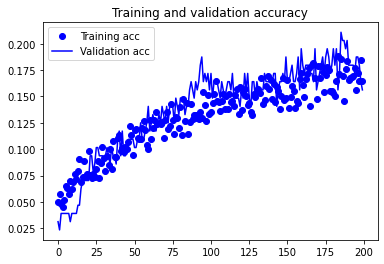

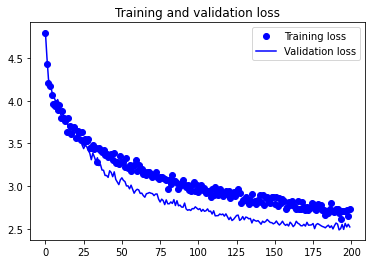

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Fine tuning last several layers.

In [38]:
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [39]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-39-4287107a2cee>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/200
67/67 [==============================] - 42s 531ms/step - loss: 2.6571 - acc: 0.1891 - val_loss: 2.5297 - val_acc: 0.1875
Epoch 2/200
67/67 [==============================] - 36s 514ms/step - loss: 2.6860 - acc: 0.1891 - val_loss: 2.5580 - val_acc: 0.1719
Epoch 3/200
67/67 [==============================] - 37s 511ms/step - loss: 2.7089 - acc: 0.1713 - val_loss: 2.4464 - val_acc: 0.1797
Epoch 4/200
67/67 [==============================] - 35s 503ms/step - loss: 2.6460 - acc: 0.1713 - val_loss: 2.4987 - val_acc: 0.1641
Epoch 5/200
67/67 [==============================] - 36s 512ms/step - loss: 2.6672 - acc: 0.1751 - val_loss: 2.5021 - val_acc: 0.1719
Epoch 6/200
67/67 [==============================] - 37s 528ms/step - loss: 2.7077 - acc: 0.1882 - val_loss: 2.5079 - val_acc: 0.1797
Epoch 7/200
67/67 [==============================] - 35s 509ms/step - loss: 2.6847 - acc: 0.1713 - val_loss: 2.5330 - val_acc: 0.1953
Epoch 8/200
67/67 [==============================] - 36s 517ms

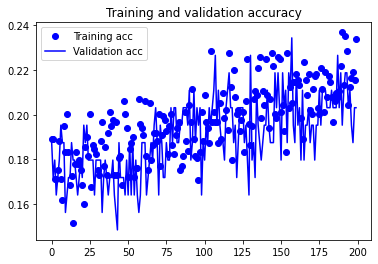

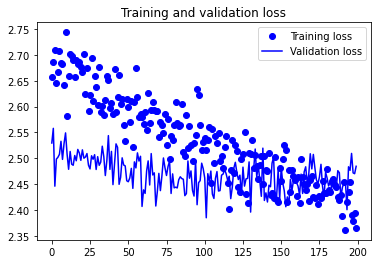

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Download the model


In [45]:
os.makedirs('/content/drive/My Drive/cut_panoramic', exist_ok=True)
model.save('/content/drive/My Drive/cut_panoramic/Flimpano_Male_200.h5')

In [42]:
# from google.colab import files
# files.download('./content/drive/My Drive/cut_panoramic/Flimpano_Male_200.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>